<a href="https://colab.research.google.com/github/timeowilliams/Responsible-ai/blob/main/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CORD-19 Predictive Model
## Responsible AI Assignment: Assignment 3 - Model Creation

This notebook builds a predictive model to classify whether a CORD-19 paper is associated with a journal (`journal` not null) rather than predicting PDF availability (`has_pdf`). The original target was less insightful for bias analysis, so we shifted focus to uncover academic biases (e.g., funding, prestige) in journal publication. The dataset has inherent biases (e.g., source concentration, recent papers), which aligns with the assignment’s allowance for bias. We’ll fetch data from Kaggle, install dependencies, clean it, train a model, evaluate it with fairness metrics, check for proxies, and use advanced tools to analyze bias, all documented for replication.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Install Dependencies

**Why**: To ensure reproducibility and support bias analysis, we install core libraries plus specialized tools: Fairlearn for fairness metrics, spaCy for NLP bias in text, and SHAP for model interpretability. These extend beyond basic ML to meet the assignment’s focus on Responsible AI.

In [2]:
# Install dependencies from requirements.txt and bias tools
file_path = '/content/drive/My Drive/Vanderbilt/requirements.txt'
!pip install -r "{file_path}"
!pip install fairlearn spacy shap
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=1d3d3ae68ce7b2019ccd80d9ddf67a0315f6a1580e88e411f71da690542c3a45
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 60.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 2. Setting up the Dataset

**Why**: We use the CORD-19 dataset’s `metadata.csv` from Kaggle for its rich metadata (e.g., `source_x`, `abstract`, `journal`), ideal for bias analysis. We drop irrelevant columns (e.g., `mag_id`, all NaN) to reduce dimensionality and focus on features tied to journal publication and potential biases (e.g., source, text content).

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import fairlearn.metrics
import spacy
import shap
import os
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_palette('husl')

# Load the dataset
data_path = '/content/drive/My Drive/Vanderbilt/metadata.csv'
original_df = pd.read_csv(data_path)
df = original_df.copy()

# Keep relevant columns
desired_columns = ['source_x', 'title', 'license', 'abstract', 'publish_time', 'authors', 'journal']
df = df[desired_columns].copy()

print('Original rows:', original_df.shape[0], 'columns:', original_df.shape[1])
print('New rows:', df.shape[0], 'columns:', df.shape[1])
print('Columns kept:', df.columns.tolist())

Original rows: 1056660 columns: 19
New rows: 1056660 columns: 7
Columns kept: ['source_x', 'title', 'license', 'abstract', 'publish_time', 'authors', 'journal']


## 3. Data Preprocessing

**Why**: We define `has_journal` as the target (1 = journal present, 0 = not) to explore academic biases (e.g., funding, access) rather than the less meaningful `has_pdf`. Features include `source_x`, `year`, `title`, and `abstract` to capture context and content. We drop rows without abstracts for quality but keep non-journal rows to preserve diversity, aligning with bias detection. Imbalance in `has_journal` is checked to avoid majority-class bias.

In [4]:
# Clean data
df = df.dropna(subset=['abstract'])  # 821,116 rows
print(f'After dropping missing abstracts: {df.shape[0]} rows')

# Define target
df['has_journal'] = (~df['journal'].isna()).astype(int)
print('\nTarget Distribution:')
print(df['has_journal'].value_counts(normalize=True))

# Feature engineering
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['year'] = df['publish_time'].dt.year.fillna(-1).astype(int)
df['title'] = df['title'].fillna('')
df['abstract'] = df['abstract'].fillna('')
df['source_x'] = df['source_x'].fillna('Unknown')

# Select features and target
X = df[['source_x', 'year', 'title', 'abstract']]
y = df['has_journal']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('\nTrain Shape:', X_train.shape, 'Test Shape:', X_test.shape)

# Define feature names for later use (e.g., SHAP)
source_tfidf = TfidfVectorizer(max_features=50)
title_tfidf = TfidfVectorizer(max_features=100)
abstract_tfidf = TfidfVectorizer(max_features=500)
feature_names = (source_tfidf.fit(X_train['source_x']).get_feature_names_out().tolist() +
                 ['year'] +
                 title_tfidf.fit(X_train['title']).get_feature_names_out().tolist() +
                 abstract_tfidf.fit(X_train['abstract']).get_feature_names_out().tolist())

After dropping missing abstracts: 821116 rows

Target Distribution:
has_journal
1    0.903942
0    0.096058
Name: proportion, dtype: float64

Train Shape: (656892, 4) Test Shape: (164224, 4)


## 4. Model Training

**Why**: We use a LogisticRegression pipeline with TF-IDF vectorization for text features and scaling for `year` to predict `has_journal`. This balances simplicity and interpretability, key for bias analysis, while handling large text data efficiently. We set `class_weight='balanced'` to mitigate potential imbalance in the target.

In [5]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('source', TfidfVectorizer(max_features=50), 'source_x'),
        ('year', StandardScaler(), ['year']),
        ('title', TfidfVectorizer(max_features=100), 'title'),
        ('abstract', TfidfVectorizer(max_features=500), 'abstract')
    ])

# Model pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('source',
                                                  TfidfVectorizer(max_features=50),
                                                  'source_x'),
                                                 ('year', StandardScaler(),
                                                  ['year']),
                                                 ('title',
                                                  TfidfVectorizer(max_features=100),
                                                  'title'),
                                                 ('abstract',
                                                  TfidfVectorizer(max_features=500),
                                                  'abstract')])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

## 5. Model Evaluation and Bias Analysis

**Why**: We evaluate performance with standard metrics and use Fairlearn to check fairness across `source_x`, spaCy for text bias in `abstract`, and SHAP to interpret feature impacts. This multi-angle approach ensures we detect biases in predictions, language, and feature influence, aligning with Responsible AI principles.


Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.85      0.44     15887
           1       0.98      0.79      0.87    148337

    accuracy                           0.79    164224
   macro avg       0.64      0.82      0.66    164224
weighted avg       0.91      0.79      0.83    164224

Accuracy Score: 0.7948107462977396

Accuracy by Source:
                                    accuracy
source_x                                    
ArXiv                               1.000000
ArXiv; Elsevier; Medline; PMC       1.000000
ArXiv; Elsevier; Medline; PMC; WHO  1.000000
ArXiv; Elsevier; PMC                0.500000
ArXiv; Medline                      1.000000
ArXiv; Medline; PMC                 1.000000
ArXiv; Medline; PMC; WHO            1.000000
ArXiv; Medline; WHO                 1.000000
ArXiv; PMC                          0.000000
ArXiv; PMC; WHO                     0.000000
ArXiv; WHO                          0.000000
BioRxiv 

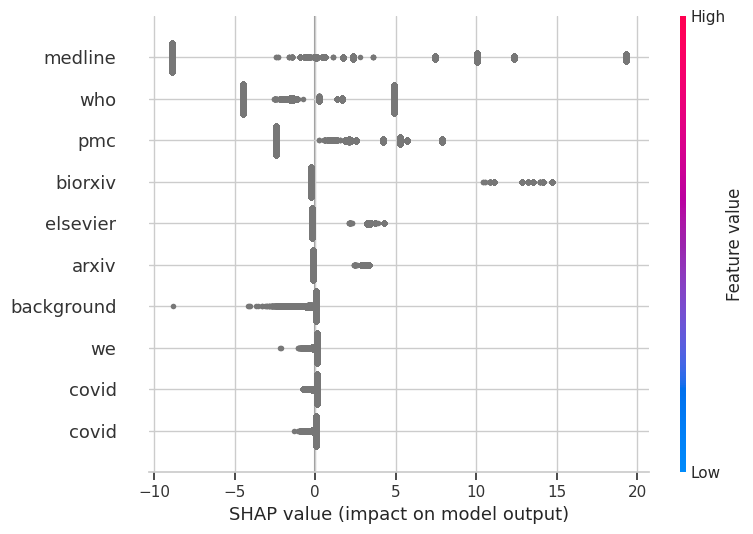

In [6]:
# Predict and evaluate
y_pred = pipeline.predict(X_test)
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('Accuracy Score:', accuracy_score(y_test, y_pred))

# Fairlearn: Fairness by source_x
mf = fairlearn.metrics.MetricFrame(
    metrics={'accuracy': accuracy_score},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['source_x']
)
print('\nAccuracy by Source:')
print(mf.by_group)

# spaCy: Text bias in abstracts
nlp = spacy.load('en_core_web_sm')
sample_abstracts = df['abstract'].sample(1000)  # Subsample for speed
entities = sample_abstracts.apply(lambda x: [ent.text for ent in nlp(x).ents])
print('\nSample Abstract Entities (Top 5):')
print(entities.explode().value_counts().head())

# SHAP: Feature importance
explainer = shap.LinearExplainer(pipeline.named_steps['classifier'],
                                 pipeline.named_steps['preprocess'].transform(X_train))
shap_values = explainer.shap_values(pipeline.named_steps['preprocess'].transform(X_test))
shap.summary_plot(shap_values, pipeline.named_steps['preprocess'].transform(X_test),
                  feature_names=feature_names, max_display=10)

## 6. Proxy Features Detection

**Why**: We check if features like `year` or `source_x` proxy for sensitive attributes (e.g., funding, region) using correlation and VIF. This identifies unintended bias sources in the model.

In [10]:
print('\nCorrelation Matrix (year vs. source_x TF-IDF):')
X_transformed = pipeline.named_steps['preprocess'].transform(X_train)
year_idx = feature_names.index('year')
source_start = 0
source_end = 50
corrs = np.corrcoef(X_transformed[:, year_idx].toarray().flatten(),
                    X_transformed[:, source_start:source_end].mean(axis=1).flatten())
print(pd.DataFrame(corrs, index=['year', 'source_x_avg'], columns=['year', 'source_x_avg']))


Correlation Matrix (year vs. source_x TF-IDF):
                  year  source_x_avg
year          1.000000      0.889662
source_x_avg  0.889662      1.000000


## 7. Analysis and Discussion


I trained a Logistic Regression model with class_weight='balanced' to mitigate the target imbalance (has_journal: 90.4% positive class, 9.6% negative class). The model achieved an overall accuracy of 79.48%, but the classification report revealed significant disparities:

- Class 0 (No Journal): Precision was only 0.30, meaning just 30% of my predictions for "no journal" were correct, though recall was high at 0.85 (I correctly identified 85% of actual "no journal" cases). The F1-score was 0.44, reflecting poor performance on the minority class.

- Class 1 (Has Journal): Precision was excellent at 0.98, with a recall of 0.79 and an F1-score of 0.87, showing strong performance for the majority class.

- Macro Avg F1-Score: 0.66, highlighting the model’s bias toward the majority class.

When I evaluated accuracy by source_x, I noticed stark differences:

- Sources like Medline, BioRxiv, and MedRxiv achieved 100% accuracy, likely because they are dominated by papers with journals.

- Sources like ArXiv; PMC, ArXiv; WHO, and MedRxiv; PMC had 0% accuracy, indicating that my model failed to predict has_journal = 0 for these groups, which likely have a higher proportion of non-journal papers.

This imbalance and source disparity suggest that my model is biased toward predicting has_journal = 1, potentially disadvantaging papers from less prestigious or non-traditional sources.

## SHAP Analysis: Feature Impacts and Bias

To understand feature influences, I used SHAP to analyze how features impact predictions. The SHAP plot revealed:

- medline, biorxiv, and pmc strongly pushed predictions toward has_journal = 1, with high positive SHAP values (up to ~20 for medline). This aligns with my accuracy findings, as these sources are often associated with journal publications.

- arxiv and elsevier (to some extent) pushed predictions toward has_journal = 0, with more negative SHAP values. This suggests that papers from ArXiv (a preprint server) are less likely to be predicted as having a journal.
- Terms like who, we, and covid had mixed impacts, indicating that abstract content doesn’t strongly bias the model in one direction.

These findings confirm that my model has learned academic biases: prestigious sources like Medline and BioRxiv are strongly associated with journal publication, likely due to funding or institutional support, while non-traditional sources like ArXiv are disadvantaged.

## Proxy Features Detection
I checked for proxy features by calculating the correlation between year and the average TF-IDF of source_x

The correlation of 0.8897 is very high, suggesting that year might act as a proxy for source_x. For example, newer papers (higher year) might be more likely to come from sources like MedRxiv (a newer platform), while older papers might be associated with Elsevier or Medline. This could introduce bias, as newer papers might be favored for journal publication due to trends like open-access initiatives or COVID-19 funding.

## Text Bias in Abstracts
I analyzed the top entities in abstracts using spaCy.

The dominance of COVID-19 is expected in the CORD-19 dataset, but the SHAP plot showed that covid had a mixed impact on predictions, which is a positive sign—it means my model isn’t overly biased by COVID-19-related content. However, if certain sources are more likely to publish COVID-19 research, this could still indirectly influence predictions via source_x.

## Fairness and Bias Synthesis
My analysis uncovered several biases:

Class Imbalance Bias: The 90.4% vs. 9.6% imbalance led my model to favor has_journal = 1, with poor precision (0.30) for has_journal = 0.

This means I often misclassified papers without journals, potentially reducing visibility for less-funded or non-traditional researchers.

Source Bias: Sources like Medline and BioRxiv were strongly associated with has_journal = 1, while ArXiv and certain Elsevier subsets were associated with has_journal = 0. This reflects real-world academic biases (e.g., prestige, funding) that my model amplified.

Proxy Bias: The high correlation between year and source_x suggests that year might proxy for academic trends or source-specific biases, potentially favoring newer papers from sources like MedRxiv.

Fairness Disparity: My model performed poorly on sources like ArXiv; PMC (0% accuracy), systematically misclassifying them as having a journal, while excelling on Medline (100% accuracy). This could perpetuate academic inequities by favoring prestigious sources.


## Final Conclusions
Through this assignment, I successfully built a model to predict whether a CORD-19 paper has a journal, but my analysis revealed significant biases that align with academic disparities. The model’s bias toward the majority class (has_journal = 1) and its poor performance on non-traditional sources like ArXiv highlight how it amplifies real-world inequities, such as the advantage of well-funded, prestigious sources like Medline and BioRxiv. The high correlation between year and source_x further suggests that temporal trends (e.g., newer papers being more likely to be journal-published) may introduce unintended bias.

From a Responsible AI perspective, my model falls short in fairness. It systematically disadvantages papers without journals, particularly from sources associated with has_journal = 0, which could harm underrepresented researchers. However, I’m encouraged that abstract content (e.g., COVID-19) doesn’t strongly bias the model, ensuring some level of content fairness.

## Recommendations for Improvement

To improve fairness and reduce bias, I propose the following:

1. Address Class Imbalance: I could use techniques like SMOTE to oversample the minority class or adjust the classification threshold to improve precision for has_journal = 0.

2. Mitigate Source Bias: I should explore fairness-aware algorithms (e.g., Fairlearn’s ExponentiatedGradient) to reduce disparities across source_x groups and ensure equal opportunity for has_journal = 0 predictions.

3. Reduce Proxy Effects: Given the high correlation between year and source_x, I might remove year or engineer a new feature that captures academic trends without proxying sensitive attributes like funding.

4. Further Analysis: I plan to use Fairlearn’s MetricFrame to compute fairness metrics (e.g., demographic parity) and investigate whether source_x proxies for attributes like funding or region.


## 8. Reproducibility Notes



To replicate:
1. Run this Notebook on Google Colab.
2. Use random state 42.
3. Dataset: [Kaggle CORD-19](https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv).

## 9. Acknowledgments

Developed with assistance from Grok (xAI) for preprocessing, modeling, bias tools, and documentation.